## Using Distilbert sequence classifier for classifing into clubbed parent classes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# importing augmented data
df = pd.read_csv('augmented_labelled_data.csv')
df.head()

,Analysis,Attribute,Standard names
0,hplc,aex-hplc total acidic peaks,aex acidic peaks
1,bio_icief,aex hplc-acidic peaks,aex acidic peaks
2,hplc,aex total acidic peaks,aex acidic peaks
3,hplc,aex-hplc acidic peaks,aex acidic peaks
4,bio_icief,aex-hplc total acidic peaks,aex acidic peaks


In [3]:
df.shape

(3067, 3)

In [4]:
df['Standard names'].value_counts()

Standard names
icief main peak                   373
sds-page (non-reduced) purity     228
sds-page (reduced) purity         208
icief acidic peaks                208
ph                                188
icief basic peaks                 187
potency by binding elisa          167
ce-sds (non-reduced) purity       160
se-hplc lmw                       156
ce-sds (reduced) purity           155
se-hplc hmw                       142
ce-sds (non-reduced) hhl          121
se-hplc monomer                   107
rp-hplc purity                    101
cex main peak                      79
protein concentration (a280)       73
cex acidic peaks                   50
se-uplc hmw                        47
se-uplc lmw                        43
cex basic peaks                    40
spr binding activity               31
aex main peak                      31
potency by cell-based bioassay     26
particulate-matter >= 25-um        26
aex basic peaks                    23
aex acidic peaks                   

## Model Training

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/Users/amruthakaruturi/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
for idx, attr in df.iterrows():
    df.at[idx, "Analysis_tokens"] = " ".join(tokenizer.tokenize(attr["Analysis"]))
    df.at[idx, "Attribute_tokens"] = " ".join(tokenizer.tokenize(attr["Attribute"]))

In [7]:
# bert tokenization
attributes = df[["Analysis", "Analysis_tokens", "Attribute", "Attribute_tokens", "Standard names"]]
attributes

,Analysis,Analysis_tokens,Attribute,Attribute_tokens,Standard names
0,hplc,hp ##lc,aex-hplc total acidic peaks,ae ##x - hp ##lc total acidic peaks,aex acidic peaks
1,bio_icief,bio _ ic ##ie ##f,aex hplc-acidic peaks,ae ##x hp ##lc - acidic peaks,aex acidic peaks
2,hplc,hp ##lc,aex total acidic peaks,ae ##x total acidic peaks,aex acidic peaks
3,hplc,hp ##lc,aex-hplc acidic peaks,ae ##x - hp ##lc acidic peaks,aex acidic peaks
4,bio_icief,bio _ ic ##ie ##f,aex-hplc total acidic peaks,ae ##x - hp ##lc total acidic peaks,aex acidic peaks
...,...,...,...,...,...
3062,hiac or Ultraviolet,hi ##ac or ultraviolet,particulate-matter >= 25-um,part ##iculate - matter > = 25 - um,particulate-matter >= 25-um
3063,Enzyme-Linked Immunosorbent Assay,enzyme - linked im ##mun ##oso ##rb ##ent ass ...,binding activity or potency,binding activity or pot ##ency,potency by binding elisa
3064,potential of Hydrogen,potential of hydrogen,ph,ph,ph
3065,ph,ph,potential of Hydrogen,potential of hydrogen,ph


In [8]:
# encodings
encoding = tokenizer(attributes["Analysis"].tolist(), attributes["Attribute"].tolist(), padding="max_length", truncation=True)
encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [9]:
import torch
from torch.utils.data import Dataset

class BMSDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# label2id = {label: idx for idx, label in enumerate(attributes["Standard names"].tolist())}
label2id = {
  "ce-sds (non-reduced) hhl": 0,
  "ce-sds (non-reduced) purity": 0,
  "ce-sds (reduced) purity": 0,
  "sds-page (non-reduced) purity": 0,
  "sds-page (reduced) purity": 0,
  "rp-hplc purity": 1,
  "ief acidic peaks": 2,
  "ief basic peaks": 2,
  "ief main peak": 2,
  "icief acidic peaks": 2,
  "icief basic peaks": 2,
  "icief main peak": 2,
  "cex acidic peaks": 2,
  "cex basic peaks": 2,
  "cex main peak": 2,
  "aex acidic peaks": 2,
  "aex basic peaks": 2,
  "aex main peak": 2,
  "se-hplc hmw": 3,
  "se-hplc lmw": 3,
  "se-hplc monomer": 3,
  "se-uplc hmw": 3,
  "se-uplc lmw": 3,
  "se-uplc monomer": 3,
  "particulate-matter >= 10-um": 4,
  "particulate-matter >= 25-um": 4,
  "potency by cell-based bioassay": 5,
  "potency by binding elisa": 6,
  "spr binding activity": 7,
  "ph": 8,
  "protein concentration (a280)": 9,
  "polysorbate 80": 10
}
id2label = {idx: label for label, idx in label2id.items()}
labels = [label2id[str(label).lower()] for label in attributes["Standard names"].tolist()]

dataset = BMSDataset(encodings=encoding, labels=labels)

In [9]:
import torch

from transformers import DistilBertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=32)

model.to(device)


cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [10]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    # per_device_train_batch_size=16,  # batch size per device during training
    # per_device_eval_batch_size=64,   # batch size for evaluation
    # warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    # logging_steps=10,
    learning_rate=2e-5,
    seed=224,
    logging_strategy="epoch",
    logging_steps=1
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset,               # training dataset
)
trainer.train()
model.save_pretrained('/results')

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
384,0.635800
768,0.026500
1152,0.007000
1536,0.004000
1920,0.003100


In [12]:
model.save_pretrained('./drive/MyDrive/bmsmodels/bertseqmodel')

In [19]:
test_data = pd.read_excel("bms_data.xlsx")
test_data = test_data.fillna("")
test_data['analysis'] = test_data['analysis'].astype(str)
test_data['Attribute_name'] = test_data['Attribute_name'].astype(str)
test_data.head()

,analysis,Attribute_name
0,D_250475,IL2 INHIBITION ASSAY
1,D_95007196,PH
2,D_M00003744,ABATACEPT MAJOR BAND (REDUCED)
3,Y_SM_95011468_R,BIOASSAY
4,250684_CE_SDS_REDUC,SUM HEAVY AND LIGHT CHAIN


In [20]:
import torch

def get_prediction_set(res, coverage=0.95):
    """
    Given a tensor of class probabilities, returns the set of classes that
    collectively reach the specified coverage level (default 95%).

    Args:
    - res (torch.Tensor): Tensor of shape (1, num_classes) containing probabilities for each class.
    - coverage (float): Desired cumulative probability threshold (default 0.95).

    Returns:
    - prediction_set (list): List of class indices that make up the cumulative probability.
    - class_probabilities (list): Probabilities corresponding to each class in the prediction set.
    - cumulative_probability (float): The cumulative probability achieved by the prediction set.
    """
    probabilities = res.squeeze()  # Remove batch dimension if it exists

    # Sort probabilities in descending order and get the indices
    sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)

    # Calculate the cumulative sum of sorted probabilities
    cumulative_probs = torch.cumsum(sorted_probs, dim=0)

    # Find the index where cumulative probability reaches or exceeds the coverage threshold
    cutoff_index = (cumulative_probs >= coverage).nonzero(as_tuple=True)[0][0]

    # Get the classes and probabilities that contribute to the specified coverage
    prediction_set = sorted_indices[:cutoff_index + 1].tolist()
    class_probabilities = sorted_probs[:cutoff_index + 1].tolist()
    cumulative_probability = cumulative_probs[cutoff_index].item()

    return prediction_set, class_probabilities, cumulative_probability

In [9]:
from transformers import DistilBertForSequenceClassification

In [19]:
test_data['prediction_set'] = None
test_data['class_probabilities'] = None
test_data['labels'] = None
test_data['max_prob'] = None
test_data['label'] = None


mod = DistilBertForSequenceClassification.from_pretrained('./drive/MyDrive/bmsmodels/bertseqmodel')
mod.eval()

for idx, row in test_data.iterrows():
  ana = row["analysis"]
  attr = row["Attribute_name"]

  test_str = tokenizer(ana, attr, padding="max_length", truncation=True, return_tensors="pt")
  res = mod(**test_str)
  res = torch.softmax(res.logits, dim=1)
  prediction_set, class_probabilities, cumulative_probability = get_prediction_set(res)
  labels = [id2label[id_] for id_ in prediction_set]

  test_data.at[idx, 'prediction_set'] = labels
  test_data.at[idx, 'class_probabilities'] = class_probabilities
  test_data.at[idx, "max_prob"] = torch.max(res).item()
  test_data.at[idx, "label"] = int(res.argmax())
  print(idx, test_data.loc[idx, "label"], test_data.loc[idx, "max_prob"])

Streaming output truncated to the last 5000 lines.
2730 0 0.9994959831237793
2731 0 0.9994827508926392
2732 0 0.9994944334030151
2733 5 0.9760507941246033
2734 5 0.9764012694358826
2735 0 0.9994268417358398
2736 0 0.9993615746498108
2737 0 0.9994637370109558
2738 0 0.9994275569915771
2739 0 0.9994231462478638
2740 1 0.9961168766021729
2741 6 0.9970155954360962
2742 6 0.997365415096283
2743 0 0.9995033740997314
2744 0 0.999491810798645
2745 5 0.9759673476219177
2746 0 0.999508261680603
2747 0 0.9994964599609375
2748 5 0.6444177627563477
2749 0 0.9994980096817017
2750 0 0.9994982481002808
2751 0 0.99949049949646
2752 0 0.9995007514953613
2753 0 0.9994910955429077
2754 0 0.9994903802871704
2755 0 0.9995020627975464
2756 6 0.9972227811813354
2757 0 0.9992879033088684
2758 0 0.9993035793304443
2759 6 0.9974067807197571
2760 5 0.9764097929000854
2761 0 0.9993158578872681
2762 2 0.9995535016059875
2763 2 0.9995504021644592
2764 2 0.9995620846748352
2765 0 0.9995009899139404
2766 0 0.999316811

In [21]:
test_data['label'].value_counts()

,count
label,
0,4445
2,881
3,582
4,582
1,381
9,273
5,240
6,161
8,93


In [22]:
test_data.columns

Index(['analysis', 'Attribute_name', 'prediction_set', 'class_probabilities',
       'labels', 'max_prob', 'label'],
      dtype='object')

In [32]:
test_data['labels'] = test_data['prediction_set'].apply(lambda x:[label2id[item] for item in x])

In [35]:
test_data.drop(['prediction_set'],axis=1,inplace=True)

In [38]:
test_data.head(20)

,analysis,Attribute_name,class_probabilities,labels,max_prob,label
0,D_250475,IL2 INHIBITION ASSAY,[0.9641308188438416],[5],0.964131,5
1,D_95007196,PH,[0.997627317905426],[8],0.997627,8
2,D_M00003744,ABATACEPT MAJOR BAND (REDUCED),[0.9975391626358032],[0],0.997539,0
3,Y_SM_95011468_R,BIOASSAY,"[0.8629494905471802, 0.04849901795387268, 0.01...","[5, 9, 6, 10, 2]",0.862949,5
4,250684_CE_SDS_REDUC,SUM HEAVY AND LIGHT CHAIN,[0.9992501139640808],[0],0.99925,0
5,250580_TOTAL_PROT,PAAD,[0.9724606275558472],[9],0.972461,9
6,250580_TOTAL_PROT,SAMPLE 1 MASS,[0.9716528058052063],[9],0.971653,9
7,250684_CE_SDS_REDUC,SS RM 3 PURITY HC AND LC PEAKS,[0.9993009567260742],[0],0.999301,0
8,250683_CE_SDS_NON_RE,MAIN PEAK,[0.9989823698997498],[0],0.998982,0
9,Y_SM_95007441_R,B7 BINDING SPR,[0.979091227054596],[7],0.979091,7


In [18]:
test_data.to_csv('predicted_labels.csv',index=False)

NameError: name 'test_data' is not defined

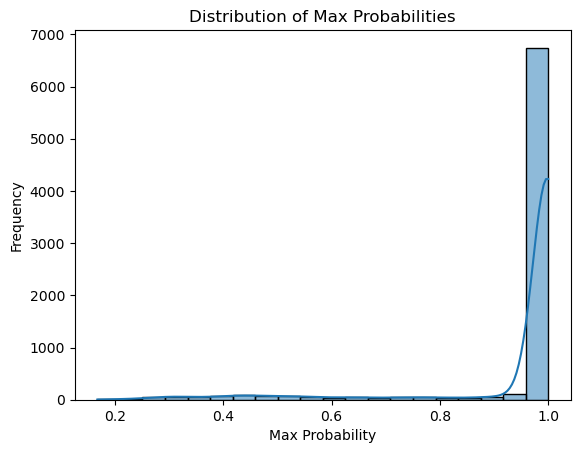

In [21]:
df3 = pd.read_csv("predicted_labels.csv")
sns.histplot(df3['max_prob'], bins=20, kde=True)
plt.title('Distribution of Max Probabilities')
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.show()

In [23]:
filtered_df = df3[df3['labels'].map(lambda x: len(x) == 1 if isinstance(x, list) else False)]

In [24]:
filtered_df

,analysis,Attribute_name,class_probabilities,labels,max_prob,label


In [15]:
len(df3['labels'])

7730